In [1]:
import copy

import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions as D

## Model

In [2]:
class MLPPolicy(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_sizes: list):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_sizes
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

        self.mean = nn.Sequential(
            nn.Linear(dims[-1], output_dim),
        )
        self.log_std = nn.Sequential(
            nn.Linear(dims[-1], output_dim),
        )

    def forward(self, state):
        common = self.net(state)
        mean = self.mean(common)
        log_std = self.log_std(common)
        std = torch.exp(log_std)
        return mean, std

## fn 

In [3]:
def compare_dist(
    policy: MLPPolicy,
    X: torch.tensor,
    y: torch.tensor,
    n_updates: int = 1,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = False,
):
    supervised_policy = copy.deepcopy(policy)
    grpo_policy = copy.deepcopy(policy)

    supervised_optimizer = torch.optim.Adam(
        supervised_policy.parameters(), lr=learning_rate
    )
    grpo_optimizer = torch.optim.Adam(grpo_policy.parameters(), lr=learning_rate)

    supervised = []
    grpo = []
    grpo_samples = []

    # train
    for _ in range(n_updates):
        supervised_policy.train()
        mean, std = supervised_policy(X)
        dist = torch.distributions.Normal(mean, std)
        if sup_log_prob:
            loss = -dist.log_prob(y).mean()
        else:
            pred = dist.rsample()
            loss = nn.MSELoss(reduction="none")(pred, y).mean(dim=-1)
        
        supervised_optimizer.zero_grad()
        loss.backward()
        supervised_optimizer.step()

        # eval
        supervised_policy.eval()
        mean, std = supervised_policy(X)
        supervised_dist = torch.distributions.Normal(mean, std)

        supervised.append(
            torch.distributions.Normal(
                supervised_dist.mean.clone(), supervised_dist.stddev.clone()
            )
        )

    # train
    for _ in range(n_updates):
        grpo_policy.train()
        mean, std = grpo_policy(X)
        dist = torch.distributions.Normal(mean, std)
        samples = dist.sample((n_generations_grpo,))

        # likelihood
        log_prob = dist.log_prob(samples).mean(dim=-1)
        # rewards
        rewards = -nn.MSELoss(reduction="none")(samples, y).mean(dim=-1)

        loss = -(log_prob * rewards).mean()
        grpo_optimizer.zero_grad()
        loss.backward()
        grpo_optimizer.step()

        # eval
        grpo_policy.eval()
        mean, std = grpo_policy(X)
        grpo_dist = torch.distributions.Normal(mean, std)

        grpo.append(
            torch.distributions.Normal(grpo_dist.mean.clone(), grpo_dist.stddev.clone())
        )
        grpo_samples.append(samples.clone())

    return (supervised, grpo, grpo_samples)

## Viz

### fixed n_updates

/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([5, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


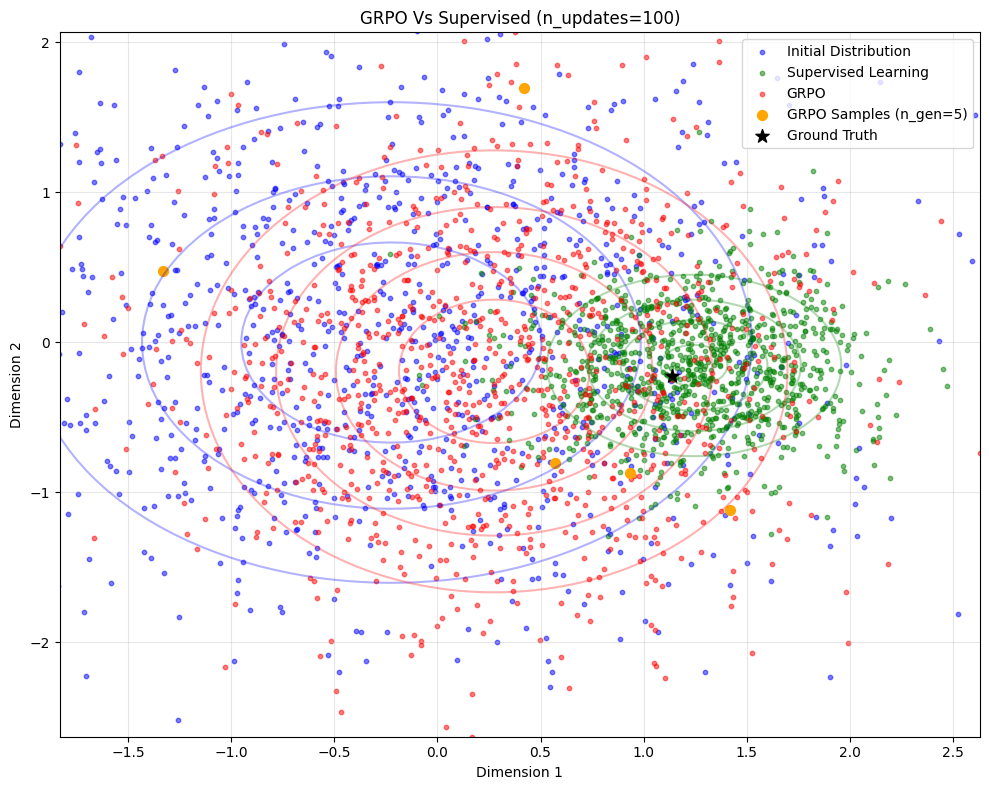

In [4]:
n_updates = 100
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]
policy = MLPPolicy(input_dim, output_dim, hidden_sizes)

# one random sample
X = torch.randn(1, input_dim)
y = torch.randn(1, output_dim)

# initial model prediction
mean, std = policy(X)
init_dist = torch.distributions.Normal(mean, std)
supervised, grpo, samples_list = compare_dist(
    policy=policy,
    n_updates=n_updates,
    X=X,
    y=y,
)

idx = -1
supervised_dist = supervised[idx]
grpo_dist = grpo[idx]
samples = samples_list[idx]

# Create a 2D plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

n_samples = 1000

# Plot initial distribution
init_samples = init_dist.sample((n_samples,)).detach().numpy().squeeze()
ax.scatter(
    init_samples[:, 0],
    init_samples[:, 1],
    c="blue",
    s=10,
    alpha=0.5,
    label="Initial Distribution",
)
# Generate grid for contour plots
x_range = np.linspace(np.min(init_samples[:, 0]), np.max(init_samples[:, 0]), 100)
y_range = np.linspace(np.min(init_samples[:, 1]), np.max(init_samples[:, 1]), 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
pos = np.dstack((X_grid, Y_grid))
init_mean = init_dist.mean.detach().numpy().flatten()
init_cov = torch.diag(init_dist.stddev.detach().flatten() ** 2).numpy()
init_rv = multivariate_normal(init_mean, init_cov)
ax.contour(X_grid, Y_grid, init_rv.pdf(pos), colors="blue", alpha=0.3, levels=4)

# Plot supervised learning distribution
sup_samples = supervised_dist.sample((n_samples,)).detach().numpy().squeeze()
ax.scatter(
    sup_samples[:, 0],
    sup_samples[:, 1],
    c="green",
    s=10,
    alpha=0.5,
    label="Supervised Learning",
)
# Generate grid for contour plots
x_range = np.linspace(np.min(sup_samples[:, 0]), np.max(sup_samples[:, 0]), 100)
y_range = np.linspace(np.min(sup_samples[:, 1]), np.max(sup_samples[:, 1]), 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
pos = np.dstack((X_grid, Y_grid))
sup_mean = supervised_dist.mean.detach().numpy().flatten()
sup_cov = torch.diag(supervised_dist.stddev.detach().flatten() ** 2).numpy()
sup_rv = multivariate_normal(sup_mean, sup_cov)
ax.contour(X_grid, Y_grid, sup_rv.pdf(pos), colors="green", alpha=0.3, levels=4)

# Plot GRPO distribution
grpo_samples = grpo_dist.sample((n_samples,)).detach().numpy().squeeze()
ax.scatter(
    grpo_samples[:, 0],
    grpo_samples[:, 1],
    c="red",
    s=10,
    alpha=0.5,
    label="GRPO",
)
# Generate grid for contour plots
x_range = np.linspace(np.min(grpo_samples[:, 0]), np.max(grpo_samples[:, 0]), 100)
y_range = np.linspace(np.min(grpo_samples[:, 1]), np.max(grpo_samples[:, 1]), 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
pos = np.dstack((X_grid, Y_grid))
grpo_mean = grpo_dist.mean.detach().numpy().flatten()
grpo_cov = torch.diag(grpo_dist.stddev.detach().flatten() ** 2).numpy()
grpo_rv = multivariate_normal(grpo_mean, grpo_cov)
ax.contour(X_grid, Y_grid, grpo_rv.pdf(pos), colors="red", alpha=0.3, levels=4)

# Plot GRPO samples
samples_np = samples.detach().numpy().reshape(-1, 2)
ax.scatter(
    samples_np[:, 0],
    samples_np[:, 1],
    c="orange",
    s=50,
    alpha=0.99,
    label="GRPO Samples (n_gen=5)",
)

# Plot ground truth
y_np = y.detach().numpy().flatten()
ax.scatter(y_np[0], y_np[1], c="black", s=100, marker="*", label="Ground Truth")

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_title(f"GRPO Vs Supervised (n_updates={n_updates})")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.set_xlim(
    np.min(np.concatenate([sup_samples, grpo_samples], axis=0)[:, 0]),
    np.max(np.concatenate([sup_samples, grpo_samples], axis=0)[:, 0]),
)
ax.set_ylim(
    np.min(np.concatenate([sup_samples, grpo_samples], axis=0)[:, 1]),
    np.max(np.concatenate([sup_samples, grpo_samples], axis=0)[:, 1]),
)
plt.tight_layout()
plt.show()

### gif

In [5]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image, display


def create_grpo_gif(
    gif_path: str = "grpo_evolution.gif",
    n_updates_max: int = 100,
    freq: int = 10,
    n_samples: int = 1000,
    auto_target: bool = True,
    n_generations_grpo: int = 5,
    sup_log_prob: bool = False,
):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes)

    # one random sample
    X = torch.randn(1, input_dim)
    if auto_target:
        y = torch.randn(1, output_dim)
    else:
        y = torch.from_numpy(np.array([[-5, 4]]).astype(np.float32))

    # initial model prediction
    mean, std = policy(X)
    init_dist = torch.distributions.Normal(mean, std)

    # Set up the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Define the range of n_updates to animate
    n_updates_range = list(range(1, n_updates_max, freq))
    supervised, grpo, samples_list = compare_dist(
        policy=policy,
        n_updates=n_updates_max,
        X=X,
        y=y,
        n_generations_grpo=n_generations_grpo,
        sup_log_prob=sup_log_prob,
    )

    def animate(frame):
        ax.clear()  # Clear the previous plot

        n_updates = n_updates_range[frame]

        # Get distributions for current n_updates
        supervised_dist = supervised[n_updates]
        grpo_dist = grpo[n_updates]
        samples = samples_list[n_updates]

        # Plot initial distribution
        init_samples = init_dist.sample((n_samples,)).detach().numpy().squeeze()
        ax.scatter(
            init_samples[:, 0],
            init_samples[:, 1],
            c="blue",
            s=10,
            alpha=0.5,
            label="Initial Distribution",
        )
        # Generate grid for contour plots
        x_range = np.linspace(
            np.min(init_samples[:, 0]), np.max(init_samples[:, 0]), 100
        )
        y_range = np.linspace(
            np.min(init_samples[:, 1]), np.max(init_samples[:, 1]), 100
        )
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        init_mean = init_dist.mean.detach().numpy().flatten()
        init_cov = torch.diag(init_dist.stddev.detach().flatten() ** 2).numpy()
        init_rv = multivariate_normal(init_mean, init_cov)
        ax.contour(X_grid, Y_grid, init_rv.pdf(pos), colors="blue", alpha=0.3, levels=4)

        # Plot supervised learning distribution
        sup_samples = supervised_dist.sample((n_samples,)).detach().numpy().squeeze()
        ax.scatter(
            sup_samples[:, 0],
            sup_samples[:, 1],
            c="green",
            s=10,
            alpha=0.5,
            label="Supervised Learning",
        )
        # Generate grid for contour plots
        x_range = np.linspace(np.min(sup_samples[:, 0]), np.max(sup_samples[:, 0]), 100)
        y_range = np.linspace(np.min(sup_samples[:, 1]), np.max(sup_samples[:, 1]), 100)
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        sup_mean = supervised_dist.mean.detach().numpy().flatten()
        sup_cov = torch.diag(supervised_dist.stddev.detach().flatten() ** 2).numpy()
        sup_rv = multivariate_normal(sup_mean, sup_cov)
        ax.contour(X_grid, Y_grid, sup_rv.pdf(pos), colors="green", alpha=0.3, levels=4)

        # Plot GRPO distribution
        grpo_samples = grpo_dist.sample((n_samples,)).detach().numpy().squeeze()
        ax.scatter(
            grpo_samples[:, 0],
            grpo_samples[:, 1],
            c="red",
            s=10,
            alpha=0.5,
            label="GRPO",
        )
        # Generate grid for contour plots
        x_range = np.linspace(
            np.min(grpo_samples[:, 0]), np.max(grpo_samples[:, 0]), 100
        )
        y_range = np.linspace(
            np.min(grpo_samples[:, 1]), np.max(grpo_samples[:, 1]), 100
        )
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        grpo_mean = grpo_dist.mean.detach().numpy().flatten()
        grpo_cov = torch.diag(grpo_dist.stddev.detach().flatten() ** 2).numpy()
        grpo_rv = multivariate_normal(grpo_mean, grpo_cov)
        ax.contour(X_grid, Y_grid, grpo_rv.pdf(pos), colors="red", alpha=0.3, levels=4)

        # Plot GRPO samples
        samples_np = samples.detach().numpy().reshape(-1, 2)
        ax.scatter(
            samples_np[:, 0],
            samples_np[:, 1],
            c="orange",
            s=50,
            alpha=0.99,
            label=f"GRPO Samples (n_gen={n_generations_grpo})",
        )

        # Plot ground truth
        y_np = y.detach().numpy().flatten()
        ax.scatter(y_np[0], y_np[1], c="black", s=100, marker="*", label="Ground Truth")

        # Set plot properties
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.set_title(f"GRPO Vs Supervised (n_updates={n_updates})")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

        # ax.set_xlim(
        #     np.min(np.concatenate([sup_samples, grpo_samples, y], axis=0)[:, 0]),
        #     np.max(np.concatenate([sup_samples, grpo_samples, y], axis=0)[:, 0]),
        # )
        # ax.set_ylim(
        #     np.min(np.concatenate([sup_samples, grpo_samples, y], axis=0)[:, 1]),
        #     np.max(np.concatenate([sup_samples, grpo_samples, y], axis=0)[:, 1]),
        # )

        ax.set_xlim(
            np.min(np.concatenate([init_samples, y], axis=0)[:, 0]) - 0.5,
            np.max(np.concatenate([init_samples, y], axis=0)[:, 0]) + 0.5,
        )
        ax.set_ylim(
            np.min(np.concatenate([init_samples, y], axis=0)[:, 1]) - 0.5,
            np.max(np.concatenate([init_samples, y], axis=0)[:, 1]) + 0.5,
        )

        print(f"Frame {frame + 1}/{len(n_updates_range)}: n_updates={n_updates}")

    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(n_updates_range), interval=200, repeat=True, blit=False
    )

    # Save as GIF
    writer = PillowWriter(fps=2)
    anim.save(gif_path, writer=writer)
    print(f"GIF saved as: {gif_path}")

    plt.close()
    return gif_path

/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([25, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Frame 1/70: n_updates=1
Frame 1/70: n_updates=1
Frame 2/70: n_updates=6
Frame 3/70: n_updates=11
Frame 4/70: n_updates=16
Frame 5/70: n_updates=21
Frame 6/70: n_updates=26
Frame 7/70: n_updates=31
Frame 8/70: n_updates=36
Frame 9/70: n_updates=41
Frame 10/70: n_updates=46
Frame 11/70: n_updates=51
Frame 12/70: n_updates=56
Frame 13/70: n_updates=61
Frame 14/70: n_updates=66
Frame 15/70: n_updates=71
Frame 16/70: n_updates=76
Frame 17/70: n_updates=81
Frame 18/70: n_updates=86
Frame 19/70: n_updates=91
Frame 20/70: n_updates=96
Frame 21/70: n_updates=101
Frame 22/70: n_updates=106
Frame 23/70: n_updates=111
Frame 24/70: n_updates=116
Frame 25/70: n_updates=121
Frame 26/70: n_updates=126
Frame 27/70: n_updates=131
Frame 28/70: n_updates=136
Frame 29/70: n_updates=141
Frame 30/70: n_updates=146
Frame 31/70: n_updates=151
Frame 32/70: n_updates=156
Frame 33/70: n_updates=161
Frame 34/70: n_updates=166
Frame 35/70: n_updates=171
Frame 36/70: n_updates=176
Frame 37/70: n_updates=181
Frame 38

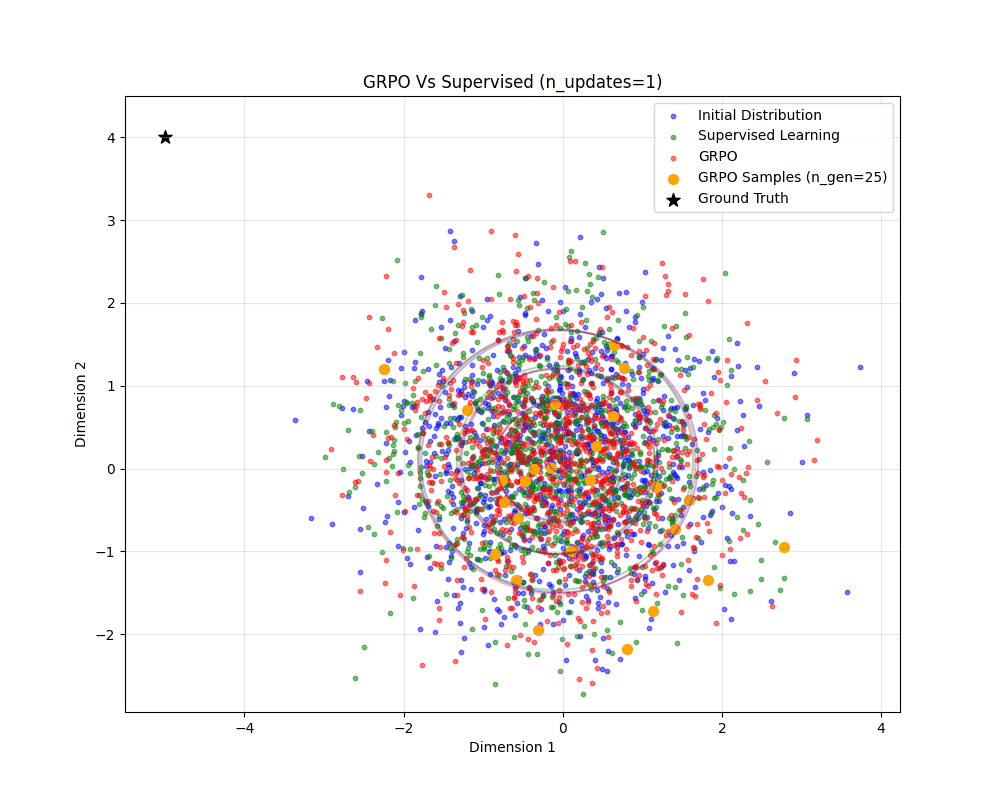

In [19]:
gif_path = create_grpo_gif(
    gif_path="rsample_far_25gen.gif", n_updates_max=350, freq=5, n_samples=1000, auto_target=False, n_generations_grpo=25, sup_log_prob=False
)
display(Image(filename=gif_path))

## Real world data

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

### load data

In [6]:
# 2. California Housing (1D output)
def create_california_housing_data():
    """Predict median house values in California districts"""
    housing = fetch_california_housing()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(housing.data)
    y_scaled = scaler_y.fit_transform(housing.target.reshape(-1, 1))

    X_torch = torch.from_numpy(X_scaled.astype(np.float32))
    y_torch = torch.from_numpy(y_scaled.astype(np.float32))

    return X_torch, y_torch


# 3. Synthetic 2D output task - Robot arm control
def create_robot_arm_data(n_samples=100):
    """Predict end-effector position (x,y) from joint angles"""
    # 4 joint angles as input
    joint_angles = np.random.uniform(-np.pi, np.pi, (n_samples, 4))

    # Simple forward kinematics: end effector position
    L1, L2, L3, L4 = 1.0, 0.8, 0.6, 0.4  # link lengths

    x = (
        L1 * np.cos(joint_angles[:, 0])
        + L2 * np.cos(joint_angles[:, 0] + joint_angles[:, 1])
        + L3 * np.cos(joint_angles[:, 0] + joint_angles[:, 1] + joint_angles[:, 2])
        + L4
        * np.cos(
            joint_angles[:, 0]
            + joint_angles[:, 1]
            + joint_angles[:, 2]
            + joint_angles[:, 3]
        )
    )

    y = (
        L1 * np.sin(joint_angles[:, 0])
        + L2 * np.sin(joint_angles[:, 0] + joint_angles[:, 1])
        + L3 * np.sin(joint_angles[:, 0] + joint_angles[:, 1] + joint_angles[:, 2])
        + L4
        * np.sin(
            joint_angles[:, 0]
            + joint_angles[:, 1]
            + joint_angles[:, 2]
            + joint_angles[:, 3]
        )
    )

    end_effector_pos = np.column_stack([x, y])

    # Add some noise
    end_effector_pos += np.random.normal(0, 0.05, end_effector_pos.shape)

    X_torch = torch.from_numpy(joint_angles.astype(np.float32))
    y_torch = torch.from_numpy(end_effector_pos.astype(np.float32))

    return X_torch, y_torch

# Example usage with one of these datasets:
# X_real, y_real, scaler = create_robot_arm_data(n_samples=1)
# print(f"Input shape: {X_real.shape}, Output shape: {y_real.shape}")

### train test split

In [7]:
X, y = create_robot_arm_data(n_samples=1000)
# X, y = create_california_housing_data()
print(f"Input shape: {X.shape}, Output shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Select n random points from train and test datasets

n_train_samples = 5
train_indices = torch.randperm(X_train.size(0))[:n_train_samples]
X_train_sample = X_train[train_indices]
y_train_sample = y_train[train_indices]

n_test_samples = 3
test_indices = torch.randperm(X_test.size(0))[:n_test_samples]
X_test_sample = X_test[test_indices]
y_test_sample = y_test[test_indices]

print(f"Selected {n_train_samples} samples from train set: {X_train_sample.shape}")
print(f"Selected {n_test_samples} samples from test set: {X_test_sample.shape}")

Input shape: torch.Size([1000, 4]), Output shape: torch.Size([1000, 2])
X_train shape: torch.Size([670, 4]), X_test shape: torch.Size([330, 4])
Selected 5 samples from train set: torch.Size([5, 4])
Selected 3 samples from test set: torch.Size([3, 4])


### fn

In [8]:
def batch_compare_dist(
    policy: MLPPolicy,
    X_train: torch.tensor,
    y_train: torch.tensor,
    X_test: torch.tensor,
    y_test: torch.tensor,
    n_updates: int = 1,
    n_generations_grpo: int = 5,
    learning_rate: float = 0.001,
    sup_log_prob: bool = False,
):
    supervised_policy = copy.deepcopy(policy)
    grpo_policy = copy.deepcopy(policy)

    supervised_optimizer = torch.optim.Adam(
        supervised_policy.parameters(), lr=learning_rate
    )
    grpo_optimizer = torch.optim.Adam(grpo_policy.parameters(), lr=learning_rate)

    supervised = {"train": [], "test": []}
    grpo = {"train": [], "test": []}
    grpo_samples = {"train": []}
    losses = {
        "train": {"supervised": [], "grpo": []},
        "test": {"supervised": [], "grpo": []},
    }

    # supervised
    for _ in range(n_updates):
        supervised_policy.train()
        mean, std = supervised_policy(X_train)
        dist = D.Independent(D.Normal(mean, std), reinterpreted_batch_ndims=1)
        supervised["train"].append(
            D.Independent(D.Normal(mean.clone(), std.clone()), reinterpreted_batch_ndims=1)
        )
        if sup_log_prob:
            loss = -dist.log_prob(y_train).mean()
        else:
            pred = dist.rsample()
            loss = nn.MSELoss(reduction="none")(pred, y_train).mean()

        supervised_optimizer.zero_grad()
        loss.backward()
        supervised_optimizer.step()

        losses["train"]["supervised"].append(
            nn.MSELoss(reduction="none")(dist.sample(), y_train).mean().item()
        )

        # eval
        supervised_policy.eval()
        mean, std = supervised_policy(X_test)

        supervised["test"].append(
            D.Independent(D.Normal(mean.clone(), std.clone()), reinterpreted_batch_ndims=1)
        )

        dist_test = D.Independent(D.Normal(mean, std), reinterpreted_batch_ndims=1)
        test_loss = nn.MSELoss(reduction="none")(dist_test.rsample(), y_test).mean()
        losses["test"]["supervised"].append(test_loss.item())

    # grpo
    for _ in range(n_updates):
        grpo_policy.train()
        mean, std = grpo_policy(X_train)
        dist = torch.distributions.Normal(mean, std)
        grpo["train"].append(
            D.Independent(D.Normal(mean.clone(), std.clone()), reinterpreted_batch_ndims=1)
        )
        samples = dist.sample((n_generations_grpo,))

        # likelihood
        log_prob = dist.log_prob(samples).mean(dim=-1)
        # rewards
        rewards = -nn.MSELoss(reduction="none")(samples, y_train).mean(dim=-1)

        loss = -(log_prob * rewards).mean()
        grpo_optimizer.zero_grad()
        loss.backward()
        grpo_optimizer.step()

        losses["train"]["grpo"].append(
            nn.MSELoss(reduction="none")(dist.sample(), y_train).mean().item()
        )

        # eval
        grpo_policy.eval()
        mean, std = grpo_policy(X_test)

        grpo["test"].append(
            D.Independent(
                D.Normal(mean.clone(), std.clone()), reinterpreted_batch_ndims=1
            )
        )
        grpo_samples["train"].append(samples.clone())

        dist_test = D.Independent(D.Normal(mean, std), reinterpreted_batch_ndims=1)
        test_loss = nn.MSELoss(reduction="none")(dist_test.sample(), y_test).mean()
        losses["test"]["grpo"].append(test_loss.item())

    return (supervised, grpo, grpo_samples, losses)


### viz

/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5, 2])) that is different to the input size (torch.Size([5, 5, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


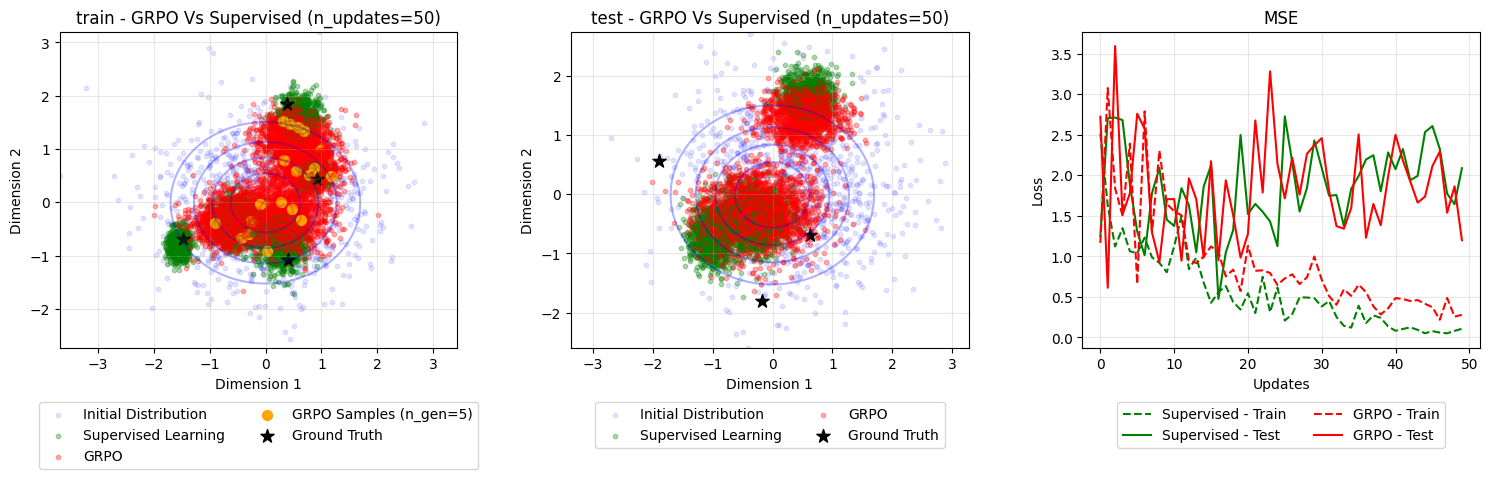

In [9]:
n_updates = 50
input_dim = 4
output_dim = 2
hidden_sizes = [64, 64]
policy = MLPPolicy(input_dim, output_dim, hidden_sizes)

# initial model prediction
mean, std = policy(torch.cat([X_train_sample, X_test_sample], dim=0))
init_dist = D.Independent(D.Normal(mean, std), reinterpreted_batch_ndims=1)
supervised, grpo, samples_list, losses = batch_compare_dist(
    policy=policy,
    n_updates=n_updates,
    X_train=X_train_sample,
    y_train=y_train_sample,
    X_test=X_test_sample,
    y_test=y_test_sample,
)

idx = -1

# Create a 2D plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

n_samples = 1000
init_samples_allsq = init_dist.sample((n_samples,)).detach().numpy().squeeze()

for ax_idx, mode in enumerate(["train", "test"]):
    sample_size = len(eval(f"X_{mode}_sample"))
    if mode == "train":
        init_samples_all = init_samples_allsq[:, :len(X_train_sample)]
    else:
        init_samples_all = init_samples_allsq[:, len(X_train_sample):]
    sup_samples_all = supervised[mode][idx].sample((n_samples,)).detach().numpy().squeeze()
    grpo_samples_all = grpo[mode][idx].sample((n_samples,)).detach().numpy().squeeze()

    for example in range(sample_size):
        init_samples = init_samples_all[:, example, :]
        sup_samples = sup_samples_all[:, example, :]
        grpo_samples = grpo_samples_all[:, example, :]
        if mode == "train":
            samples_np = samples_list[mode][idx][:, example, :].detach().numpy().reshape(-1, 2)
        supervised_dist = supervised[mode][idx]
        grpo_dist = grpo[mode][idx]
        
        if example==0:
            # Plot initial distribution
            ax[ax_idx].scatter(
                init_samples[:, 0],
                init_samples[:, 1],
                c="blue",
                s=10,
                alpha=0.1,
                label="Initial Distribution" if example == 0 else None,
            )
            # Generate grid for contour plots
            x_range = np.linspace(np.min(init_samples[:, 0]), np.max(init_samples[:, 0]), 100)
            y_range = np.linspace(np.min(init_samples[:, 1]), np.max(init_samples[:, 1]), 100)
            X_grid, Y_grid = np.meshgrid(x_range, y_range)
            pos = np.dstack((X_grid, Y_grid))
            init_mean = init_dist.mean[example].detach().numpy().flatten()
            init_cov = torch.diag(init_dist.stddev[example].detach().flatten() ** 2).numpy()
            init_rv = multivariate_normal(init_mean, init_cov)
            ax[ax_idx].contour(
                X_grid, Y_grid, init_rv.pdf(pos), colors="blue", alpha=0.3, levels=4
            )

        # Plot supervised learning distribution
        ax[ax_idx].scatter(
            sup_samples[:, 0],
            sup_samples[:, 1],
            c="green",
            s=10,
            alpha=0.3,
            label="Supervised Learning" if example == 0 else None,
        )
        # Generate grid for contour plots
        x_range = np.linspace(np.min(sup_samples[:, 0]), np.max(sup_samples[:, 0]), 100)
        y_range = np.linspace(np.min(sup_samples[:, 1]), np.max(sup_samples[:, 1]), 100)
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        sup_mean = supervised_dist.mean[example].detach().numpy().flatten()
        sup_cov = torch.diag(
            supervised_dist.stddev[example].detach().flatten() ** 2
        ).numpy()
        sup_rv = multivariate_normal(sup_mean, sup_cov)
        ax[ax_idx].contour(
            X_grid, Y_grid, sup_rv.pdf(pos), colors="green", alpha=0.3, levels=4
        )

        # Plot GRPO distribution
        ax[ax_idx].scatter(
            grpo_samples[:, 0],
            grpo_samples[:, 1],
            c="red",
            s=10,
            alpha=0.3,
            label="GRPO" if example == 0 else None,
        )
        # Generate grid for contour plots
        x_range = np.linspace(np.min(grpo_samples[:, 0]), np.max(grpo_samples[:, 0]), 100)
        y_range = np.linspace(np.min(grpo_samples[:, 1]), np.max(grpo_samples[:, 1]), 100)
        X_grid, Y_grid = np.meshgrid(x_range, y_range)
        pos = np.dstack((X_grid, Y_grid))
        grpo_mean = grpo_dist.mean[example].detach().numpy().flatten()
        grpo_cov = torch.diag(grpo_dist.stddev[example].detach().flatten() ** 2).numpy()
        grpo_rv = multivariate_normal(grpo_mean, grpo_cov)
        ax[ax_idx].contour(
            X_grid, Y_grid, grpo_rv.pdf(pos), colors="red", alpha=0.3, levels=4
        )

        if mode == "train":
            # Plot GRPO samples
            ax[ax_idx].scatter(
                samples_np[:, 0],
                samples_np[:, 1],
                c="orange",
                s=50,
                alpha=0.99,
                label="GRPO Samples (n_gen=5)" if example == 0 else None,
            )

        # Plot ground truth
        if mode == "train":
            y_np = y_train_sample[example].detach().numpy().flatten()
        else:
            y_np = y_test_sample[example].detach().numpy().flatten()
        ax[ax_idx].scatter(
            y_np[0],
            y_np[1],
            c="black",
            s=100,
            marker="*",
            label="Ground Truth" if example == 0 else None,
        )

    ax[ax_idx].set_title(f"{mode} - GRPO Vs Supervised (n_updates={n_updates})")
    ax[ax_idx].set_xlabel("Dimension 1")
    ax[ax_idx].set_ylabel("Dimension 2")
    ax[ax_idx].legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    ax[ax_idx].grid(True, alpha=0.3)
    ax[ax_idx].set_xlim(
        np.min(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 0]
        ),
        np.max(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 0]
        ),
    )
    ax[ax_idx].set_ylim(
        np.min(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 1]
        ),
        np.max(
            np.concatenate(
                [init_samples_all, sup_samples_all, grpo_samples_all], axis=1
            )[:, :, 1]
        ),
    )

# plot losses
ax[-1].plot(
    range(n_updates),
    losses["train"]["supervised"],
    label="Supervised - Train",
    color="green",
    linestyle="--",
)
ax[-1].plot(
    range(n_updates),
    losses["test"]["supervised"],
    label="Supervised - Test",
    color="green",
)
ax[-1].plot(
    range(n_updates),
    losses["train"]["grpo"],
    label="GRPO - Train",
    color="red",
    linestyle="--",
)
ax[-1].plot(
    range(n_updates),
    losses["test"]["grpo"],
    label="GRPO - Test",
    color="red",
)
ax[-1].set_title("MSE")
ax[-1].set_xlabel("Updates")
ax[-1].set_ylabel("Loss")
ax[-1].legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
ax[-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# The End

y_test_sample

y_test_sample

In [36]:
y_test_sample.shape


torch.Size([5, 2])